In [2]:
import sys
sys.path.append('../../code/')

In [3]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
# from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
# from postprocessing import factuality
# from postprocessing import bias
from libs.visuals import grid
from libs.visuals import constants as grid_constants

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [ ]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [5]:
PREFIX = 'temperature'

In [ ]:
files = io.get_files(BENCHMARKS_PATH, f'{PREFIX}_per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

In [ ]:
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"
df_per_attempt = df_per_attempt_all.query(query_infra).copy()
df_per_attempt.shape

In [ ]:
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.model_name = df_models_metadata.model_name.apply(lambda x: 'llama-3.3-8b' if x == 'llama-3.1-8b' else x)
df_models_metadata.shape


# Plots

In [ ]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

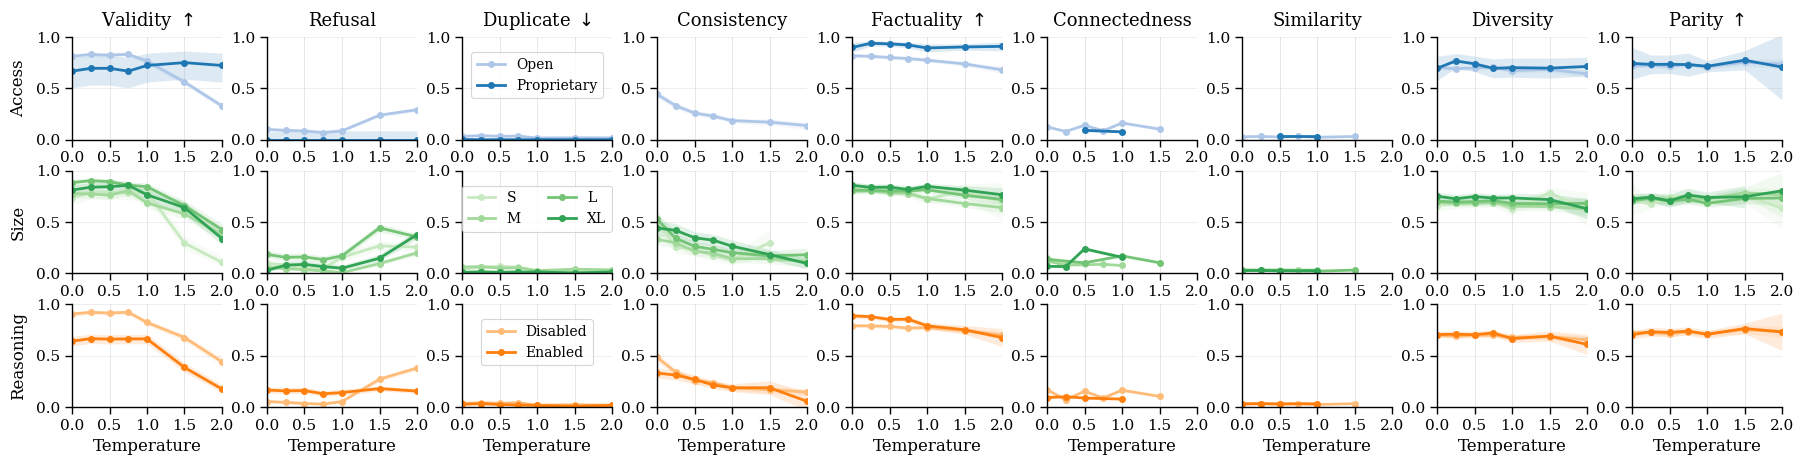

In [12]:
width_ratios = grid.width_ratios_for_split(k_panels=len(grid_constants.PANEL_INFRASTRUCTURE), bars_share=0.95, panel_ratio=1.0)

row_legend_specs = {
    "model_access": {"col": 2, "ncol": 1, "bbox_y": 0.85},
    "model_size":   {"col": 2, "ncol": 2, "bbox_y": 0.85},
    "model_class":  {"col": 2, "ncol": 1, "bbox_y": 0.85},
}

fig = grid.plot_metric_grid_temperature_lines(
    df_summary_infrastructure_group,
    panels=grid_constants.PANEL_INFRASTRUCTURE,
    group_order=grid_constants.GROUPS_ORDER,
    model_order_within_group=grid_constants.MODEL_KIND_ORDER_WITHIN_GROUP,
    group_label_map=grid_constants.GROUP_LABEL_MAP,
    model_label_map=grid_constants.MODEL_KIND_LABEL_MAP,
    group_colors=grid_constants.GROUP_COLORS,
    layout=grid.LayoutSpec(figsize=(18, 5.), wspace=0.30),
    style=grid.StyleSpec(title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10, legend_fontsize=10, legend_frameon=True, row_label_x=-0.3),
    xlim=(0.0, 2.0),
    xticks=[0.0, 0.5, 1.0, 1.5, 2.0],
    ylim=(0, 1),
    yticks=[0, 0.5, 1.0],
    row_legend_specs=row_legend_specs,
    width_ratios=width_ratios
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model_group.pdf')
fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

grid.plt.show()
grid.plt.close()

